In [70]:
#import necessary packages
import pandas as pd 
import splitfolders

from sklearn.dummy import DummyClassifier

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from keras import regularizers

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#use the splitfolders package to split our image data into train, validation, and test sets.
#this is now commented out so that we don't create a new folder each time we run the notebook

#splitfolders.ratio("Data", output="Data_Split",
#    seed=42, ratio=(.64, .16, .2), group_prefix=None, move=True)

In [3]:
#create DataGenerator objects for each set with rescaling for maximum pixel value of 255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
#create a train_generator from the training directory that has been created from the split folders package
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        'Data_Split/train',
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=4280,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary', 
        color_mode='grayscale')


Found 4280 images belonging to 2 classes.


In [5]:
#create a validation_generator from the training directory that has been created from the split folders package
validation_generator = val_datagen.flow_from_directory('Data_Split/val',
                                                        target_size=(150, 150),
                                                        batch_size=978,
                                                        class_mode='binary',
                                                        color_mode='grayscale')

Found 978 images belonging to 2 classes.


In [6]:
#create a test_generator from the training directory that has been created from the split folders package
test_generator = test_datagen.flow_from_directory('Data_Split/test',
                                                  target_size=(150, 150),
                                                  batch_size=1173,
                                                  class_mode='binary',
                                                  color_mode='grayscale')

Found 1173 images belonging to 2 classes.


In [7]:
train_data, train_labels = next(train_generator)

In [8]:
val_data, val_labels = next(validation_generator)

In [9]:
test_data, test_labels = next(test_generator)

### Dummy Model

We will create a dummy model for our baseline model that simply predicts the majority class, or in this case, that the patient has pneumonia. We can use the dummy classifier from sklearn. 

In [10]:
baseline = DummyClassifier(strategy='most_frequent')

In [11]:
baseline.fit(train_data, train_labels)

DummyClassifier(strategy='most_frequent')

In [12]:
baseline.score(train_data, train_labels)

0.7633177570093458

In [26]:
train_data = train_data.reshape(train_data.shape[0], -1)

In [27]:
val_data = val_data.reshape(val_data.shape[0], -1)

In [28]:
train_data.shape

(4280, 22500)

In [29]:
simple_model = models.Sequential()

In [30]:
simple_model.add(layers.Dense(12, activation='relu', input_shape=(22500,)))
simple_model.add(layers.Dense(1, activation='sigmoid'))

In [31]:
simple_model.compile(optimizer='SGD', 
                       loss='binary_crossentropy',
                       metrics=['accuracy', metrics.Precision(), metrics.Recall()])

In [32]:
simple_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                270012    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 13        
Total params: 270,025
Trainable params: 270,025
Non-trainable params: 0
_________________________________________________________________


In [33]:
simple_fit = simple_model.fit(train_data,
                              train_labels,
                              epochs=10,
                              batch_size=32,
                              validation_data=(val_data, val_labels),
                              verbose=1)

Train on 4280 samples, validate on 978 samples
Epoch 1/10
4280/4280 [==============================] - 1s 265us/step - loss: 0.4782 - accuracy: 0.7664 - precision_2: 0.7694 - recall_2: 0.9908 - val_loss: 0.3789 - val_accuracy: 0.8088 - val_precision_2: 0.7976 - val_recall_2: 0.9945
Epoch 2/10
4280/4280 [==============================] - 1s 132us/step - loss: 0.3528 - accuracy: 0.8484 - precision_2: 0.8538 - recall_2: 0.9669 - val_loss: 0.3493 - val_accuracy: 0.8272 - val_precision_2: 0.8138 - val_recall_2: 0.9945
Epoch 3/10
4280/4280 [==============================] - 1s 135us/step - loss: 0.3070 - accuracy: 0.8867 - precision_2: 0.8954 - recall_2: 0.9642 - val_loss: 0.3307 - val_accuracy: 0.8640 - val_precision_2: 0.8482 - val_recall_2: 0.9945
Epoch 4/10
4280/4280 [==============================] - 1s 145us/step - loss: 0.2830 - accuracy: 0.8995 - precision_2: 0.9142 - recall_2: 0.9584 - val_loss: 0.2785 - val_accuracy: 0.9162 - val_precision_2: 0.9386 - val_recall_2: 0.9490
Epoch 5/1

In [34]:
#recreate our objects for features and labels in order to create simple convolutional neural network
train_data, train_labels = next(train_generator)

val_data, val_labels = next(validation_generator)

test_data, test_labels = next(test_generator)

In [77]:
basic_cnn_model = models.Sequential()
basic_cnn_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                    input_shape=(150, 150, 1)))
basic_cnn_model.add(layers.MaxPooling2D((2, 2)))
basic_cnn_model.add(layers.Flatten())
basic_cnn_model.add(layers.Dense(16, activation='relu'))
basic_cnn_model.add(layers.Dense(1, activation='sigmoid'))

basic_cnn_model.compile(optimizer="adam",
                        loss='binary_crossentropy',
                        metrics=['accuracy', metrics.Recall()])

basic_cnn_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 341056)            0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)                5456912   
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 17        
Total params: 5,458,017
Trainable params: 5,458,017
Non-trainable params: 0
_________________________________________________________________


In [49]:
basic_cnn_history = basic_cnn_model.fit(train_data,
                                        train_labels,
                                        batch_size=100,
                                        epochs=10,
                                        validation_data=(val_data, val_labels))

Train on 4280 samples, validate on 978 samples
Epoch 1/10
4280/4280 [==============================] - 65s 15ms/step - loss: 0.8802 - accuracy: 0.8154 - recall_8: 0.9244 - val_loss: 0.2288 - val_accuracy: 0.8957 - val_recall_8: 0.9779
Epoch 2/10
4280/4280 [==============================] - 80s 19ms/step - loss: 0.1562 - accuracy: 0.9421 - recall_8: 0.9718 - val_loss: 0.1444 - val_accuracy: 0.9376 - val_recall_8: 0.9738
Epoch 3/10
4280/4280 [==============================] - 65s 15ms/step - loss: 0.1232 - accuracy: 0.9526 - recall_8: 0.9764 - val_loss: 0.1305 - val_accuracy: 0.9468 - val_recall_8: 0.9559
Epoch 4/10
4280/4280 [==============================] - 57s 13ms/step - loss: 0.0944 - accuracy: 0.9650 - recall_8: 0.9813 - val_loss: 0.1417 - val_accuracy: 0.9387 - val_recall_8: 0.9862
Epoch 5/10
4280/4280 [==============================] - 57s 13ms/step - loss: 0.0861 - accuracy: 0.9685 - recall_8: 0.9847 - val_loss: 0.1188 - val_accuracy: 0.9530 - val_recall_8: 0.9752
Epoch 6/10
42

/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

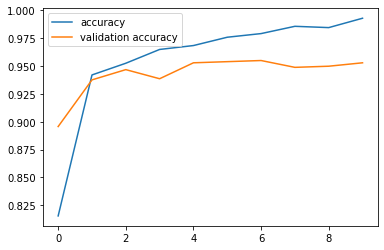

In [58]:
fig, (ax1, ax2) = plt.subplots()

sns.lineplot(basic_cnn_history.epoch, basic_cnn_history.history['accuracy'], ax=ax1, label='accuracy');
sns.lineplot(basic_cnn_history.epoch, basic_cnn_history.history['val_accuracy'], ax=ax1, label='validation accuracy');

sns.lineplot(basic_cnn_history.epoch, basic_cnn_history.history['recall_8'], ax=ax2, label='recall');
sns.lineplot(basic_cnn_history.epoch, basic_cnn_history.history['val_recall_8'], ax=ax2, label='validation recall');

In [64]:
complex_cnn_model = models.Sequential()
complex_cnn_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                      input_shape=(150, 150, 1)))
complex_cnn_model.add(layers.MaxPooling2D((2, 2)))
complex_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
complex_cnn_model.add(layers.MaxPooling2D((2,2)))
complex_cnn_model.add(layers.Flatten())
complex_cnn_model.add(layers.Dense(16, activation='relu'))
complex_cnn_model.add(layers.Dense(1, activation='sigmoid'))

complex_cnn_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Recall()])

complex_cnn_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 39200)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                627216    
_________________________________________________________________
dense_26 (Dense)             (None, 1)               

In [65]:
complex_cnn_history = complex_cnn_model.fit(train_data,
                                            train_labels,
                                            batch_size=32,
                                            epochs=10,
                                            validation_data=(val_data, val_labels))

Train on 4280 samples, validate on 978 samples
Epoch 1/10
4280/4280 [==============================] - 67s 16ms/step - loss: 0.3023 - accuracy: 0.8678 - recall_12: 0.9464 - val_loss: 0.1690 - val_accuracy: 0.9315 - val_recall_12: 0.9559
Epoch 2/10
4280/4280 [==============================] - 69s 16ms/step - loss: 0.1511 - accuracy: 0.9430 - recall_12: 0.9685 - val_loss: 0.1279 - val_accuracy: 0.9489 - val_recall_12: 0.9779
Epoch 3/10
4280/4280 [==============================] - 70s 16ms/step - loss: 0.1386 - accuracy: 0.9502 - recall_12: 0.9767 - val_loss: 0.1433 - val_accuracy: 0.9397 - val_recall_12: 0.9862
Epoch 4/10
4280/4280 [==============================] - 72s 17ms/step - loss: 0.1089 - accuracy: 0.9593 - recall_12: 0.9783 - val_loss: 0.1134 - val_accuracy: 0.9519 - val_recall_12: 0.9697
Epoch 5/10
4280/4280 [==============================] - 77s 18ms/step - loss: 0.1089 - accuracy: 0.9593 - recall_12: 0.9789 - val_loss: 0.1048 - val_accuracy: 0.9519 - val_recall_12: 0.9738
Epo

/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


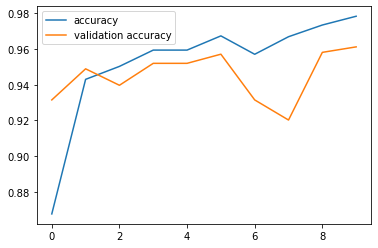

In [66]:
fig, ax = plt.subplots()

sns.lineplot(complex_cnn_history.epoch, complex_cnn_history.history['accuracy'], ax=ax, label='accuracy');
sns.lineplot(complex_cnn_history.epoch, complex_cnn_history.history['val_accuracy'], ax=ax, label='validation accuracy');

In [73]:
complex_cnn_model2 = models.Sequential()
complex_cnn_model2.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
complex_cnn_model2.add(layers.MaxPooling2D((2, 2)))
complex_cnn_model2.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
complex_cnn_model2.add(layers.MaxPooling2D((2,2)))
complex_cnn_model2.add(layers.Flatten())
complex_cnn_model2.add(layers.Dense(16, activation='relu'))
complex_cnn_model2.add(layers.Dense(1, activation='sigmoid'))

complex_cnn_model2.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Recall()])

complex_cnn_model2.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 39200)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 16)                627216    
_________________________________________________________________
dense_30 (Dense)             (None, 1)               

In [74]:
complex_cnn_history2 = complex_cnn_model2.fit(train_data,
                                              train_labels,
                                              batch_size=32,
                                              epochs=10,
                                              validation_data=(val_data, val_labels))

Train on 4280 samples, validate on 978 samples
Epoch 1/10
4280/4280 [==============================] - 68s 16ms/step - loss: 1.0227 - accuracy: 0.8016 - recall_14: 0.9884 - val_loss: 0.4545 - val_accuracy: 0.8742 - val_recall_14: 0.9917
Epoch 2/10
4280/4280 [==============================] - 66s 15ms/step - loss: 0.3701 - accuracy: 0.8993 - recall_14: 0.9838 - val_loss: 0.3345 - val_accuracy: 0.9254 - val_recall_14: 0.9724
Epoch 3/10
4280/4280 [==============================] - 67s 16ms/step - loss: 0.2974 - accuracy: 0.9234 - recall_14: 0.9819 - val_loss: 0.2920 - val_accuracy: 0.9274 - val_recall_14: 0.9724
Epoch 4/10
4280/4280 [==============================] - 65s 15ms/step - loss: 0.2745 - accuracy: 0.9231 - recall_14: 0.9786 - val_loss: 0.2762 - val_accuracy: 0.9233 - val_recall_14: 0.9697
Epoch 5/10
4280/4280 [==============================] - 62s 14ms/step - loss: 0.2514 - accuracy: 0.9343 - recall_14: 0.9786 - val_loss: 0.2562 - val_accuracy: 0.9335 - val_recall_14: 0.9572
Epo

/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


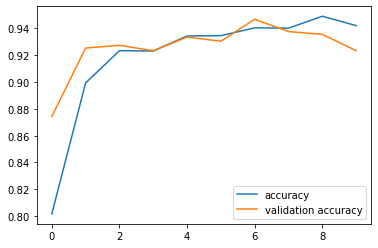

In [75]:
fig, ax = plt.subplots()

sns.lineplot(complex_cnn_history2.epoch, complex_cnn_history2.history['accuracy'], ax=ax, label='accuracy');
sns.lineplot(complex_cnn_history2.epoch, complex_cnn_history2.history['val_accuracy'], ax=ax, label='validation accuracy');

In [78]:
complex_cnn_model3 = models.Sequential()
complex_cnn_model3.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
complex_cnn_model3.add(layers.MaxPooling2D((2, 2)))
complex_cnn_model3.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
complex_cnn_model3.add(layers.MaxPooling2D((2,2)))
complex_cnn_model3.add(layers.Flatten())
complex_cnn_model3.add(layers.Dense(16, activation='relu'))
complex_cnn_model3.add(layers.Dropout(0.5))
complex_cnn_model3.add(layers.Dense(1, activation='sigmoid'))

complex_cnn_model3.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Recall()])

complex_cnn_model3.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 39200)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                627216    
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)              

In [79]:
complex_cnn_history3 = complex_cnn_model3.fit(train_data,
                                              train_labels,
                                              batch_size=32,
                                              epochs=10,
                                              validation_data=(val_data, val_labels))

Train on 4280 samples, validate on 978 samples
Epoch 1/10
4280/4280 [==============================] - 79s 19ms/step - loss: 1.0412 - accuracy: 0.7596 - recall_16: 0.9911 - val_loss: 0.4563 - val_accuracy: 0.7413 - val_recall_16: 1.0000
Epoch 2/10
4280/4280 [==============================] - 84s 20ms/step - loss: 0.4710 - accuracy: 0.7633 - recall_16: 1.0000 - val_loss: 0.3694 - val_accuracy: 0.7413 - val_recall_16: 1.0000
Epoch 3/10
4280/4280 [==============================] - 75s 17ms/step - loss: 0.4216 - accuracy: 0.7633 - recall_16: 1.0000 - val_loss: 0.3269 - val_accuracy: 0.7413 - val_recall_16: 1.0000
Epoch 4/10
4280/4280 [==============================] - 74s 17ms/step - loss: 0.3774 - accuracy: 0.7633 - recall_16: 1.0000 - val_loss: 0.3108 - val_accuracy: 0.7413 - val_recall_16: 1.0000
Epoch 5/10
4280/4280 [==============================] - 76s 18ms/step - loss: 0.3689 - accuracy: 0.7633 - recall_16: 1.0000 - val_loss: 0.3446 - val_accuracy: 0.7413 - val_recall_16: 1.0000
Epo

/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


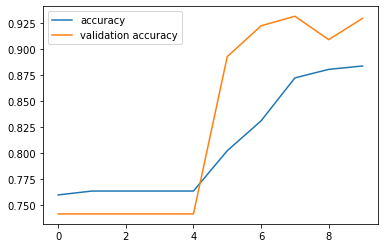

In [80]:
fig, ax = plt.subplots()

sns.lineplot(complex_cnn_history3.epoch, complex_cnn_history3.history['accuracy'], ax=ax, label='accuracy');
sns.lineplot(complex_cnn_history3.epoch, complex_cnn_history3.history['val_accuracy'], ax=ax, label='validation accuracy');

In [84]:
complex_cnn_model4 = models.Sequential()
complex_cnn_model4.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
complex_cnn_model4.add(layers.MaxPooling2D((2, 2)))
complex_cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
complex_cnn_model4.add(layers.MaxPooling2D((2,2)))
complex_cnn_model4.add(layers.Flatten())
complex_cnn_model4.add(layers.Dense(16, activation='relu'))
complex_cnn_model4.add(layers.Dropout(0.3))
complex_cnn_model4.add(layers.Dense(1, activation='sigmoid'))

complex_cnn_model4.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Recall()])

complex_cnn_model4.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 39200)             0         
_________________________________________________________________
dense_45 (Dense)             (None, 16)                627216    
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)              

In [85]:
complex_cnn_history4 = complex_cnn_model4.fit(train_data,
                                              train_labels,
                                              batch_size=32,
                                              epochs=25,
                                              validation_data=(val_data, val_labels))

Train on 4280 samples, validate on 978 samples
Epoch 1/25
4280/4280 [==============================] - 61s 14ms/step - loss: 1.0563 - accuracy: 0.7614 - recall_19: 0.9966 - val_loss: 0.4735 - val_accuracy: 0.7413 - val_recall_19: 1.0000
Epoch 2/25
4280/4280 [==============================] - 59s 14ms/step - loss: 0.4718 - accuracy: 0.7633 - recall_19: 1.0000 - val_loss: 0.3602 - val_accuracy: 0.7413 - val_recall_19: 1.0000
Epoch 3/25
4280/4280 [==============================] - 58s 14ms/step - loss: 0.4265 - accuracy: 0.7621 - recall_19: 0.9979 - val_loss: 0.3388 - val_accuracy: 0.7413 - val_recall_19: 1.0000
Epoch 4/25
4280/4280 [==============================] - 58s 14ms/step - loss: 0.4177 - accuracy: 0.7626 - recall_19: 0.9982 - val_loss: 0.3466 - val_accuracy: 0.7413 - val_recall_19: 1.0000
Epoch 5/25
4280/4280 [==============================] - 58s 14ms/step - loss: 0.3996 - accuracy: 0.7633 - recall_19: 1.0000 - val_loss: 0.3187 - val_accuracy: 0.7413 - val_recall_19: 1.0000
Epo